In [165]:
import functions as funcs
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
import shutil

In [2]:
total_df = funcs.get_image_df()

In [3]:
total_df = funcs.train_test_split_df(total_df=total_df)

In [4]:
image_annotations = (funcs.get_image_annotation(image_name=image_file_name, total_df=total_df) 
                     for image_file_name in total_df['Image File'].values)

A014_18Z_T15092_MID_x40_z0_i07j10.jpg


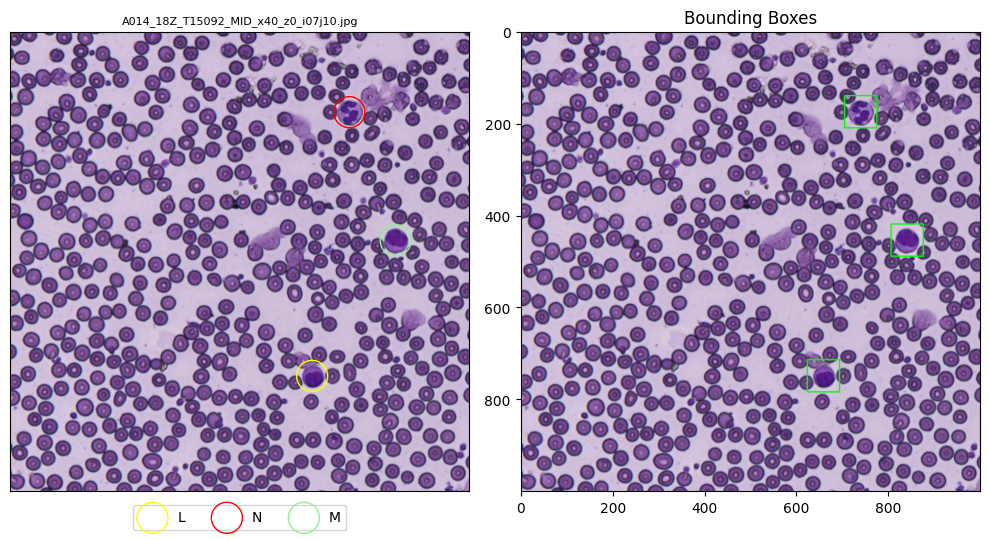

In [21]:
im_an = next(image_annotations)
print(im_an.image_name)
im_an.display_annotations()

In [22]:
im_an

Image name: A014_18Z_T15092_MID_x40_z0_i07j10.jpg
Cells:[['L', (657, 749)], ['N', (738, 175)], ['M', (839, 454)]]

In [210]:
# image_file with multiple cells -> A014_18Z_T15092_MID_x40_z0_i07j10.jpg 

def make_annotation_file(image_annotation:funcs.ImageAnnotation, file_path:str) -> None:
    """ Takes an ImageAnnotation object and creates a txt file with the image annotations """
    wbc_list = ['N', 'L', 'M', 'E', 'B']
    with open(file=file_path, mode='w') as f:
        for cell in image_annotation.cells:
            line = f"{wbc_list.index(cell.wbc_class)} {cell.center_x_normalized} {cell.center_y_normalized} {cell.width_normalized} {cell.height_normalized}\n"
            # line = (
            #     f"{wbc_list.index(cell.wbc_class)}"
            #     f"{cell.center_x_normalized}"
            #     f"{cell.center_y_normalized}"
            # )
            f.write(line)
    

In [211]:
make_annotation_file(image_annotation=im_an, file_path="test.txt")

In [51]:
funcs.get_image_path(image_file_name=im_an.image_name, total_df=total_df)

'../AI Training Sets-20231024T092556Z-001/AI Training Sets/Set4-1_WBC_Images/A014_18Z_T15092_MID_x40_z0_i07j10.jpg'

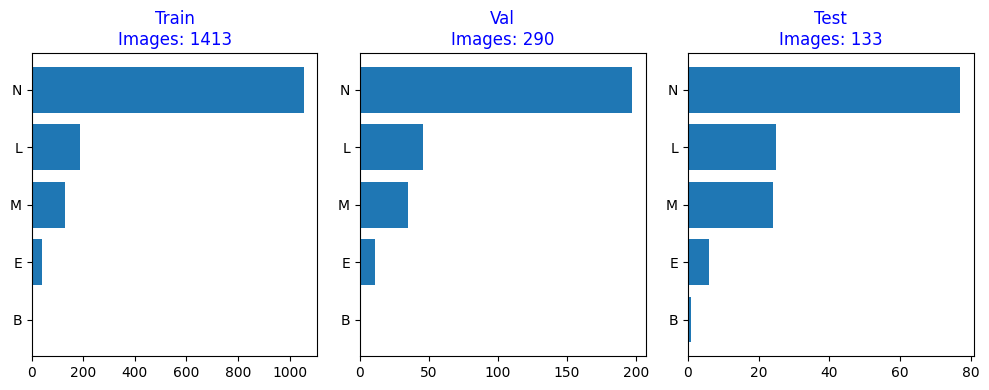

In [112]:
grouped = total_df.groupby(['train_test_val', 'wbc_class'], observed=False, sort=True).size()

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,4))
for i, cat in enumerate(total_df['train_test_val'].cat.categories):
    vals = grouped[cat].sort_values()
    tot_images = grouped[cat].values.sum()
    ax[i].set_title(f"{str(cat)}\nImages: {tot_images}", color='blue')
    ax[i].barh(vals.index, vals.values)
plt.tight_layout()
plt.show()


In [61]:
total_df.head()

,Animal ID,Animal Date,Image ID,Image File,x_coord,y_coord,wbc_class,set,train_test_val
0,18Z,2015-11-18,55725659,A014_18Z_T15092_MID_x40_z0_i01j06.jpg,183,183,N,Set4,Train
1,18Z,2015-11-18,55726671,A014_18Z_T15092_MID_x40_z0_i01j29.jpg,553,881,L,Set4,Val
2,18Z,2015-11-18,55727023,A014_18Z_T15092_MID_x40_z0_i01j37.jpg,132,848,M,Set4,Train
3,18Z,2015-11-18,55727111,A014_18Z_T15092_MID_x40_z0_i01j39.jpg,278,372,E,Set4,Train
4,18Z,2015-11-18,55727199,A014_18Z_T15092_MID_x40_z0_i01j41.jpg,821,391,N,Set4,Train


In [113]:
# For Train, Val & Test -> send image to images folder and send txt to labels folder

In [145]:
total_df[total_df['Image File'] == 'A014_18Z_T15092_MID_x40_z0_i07j10.jpg']

,Animal ID,Animal Date,Image ID,Image File,x_coord,y_coord,wbc_class,set,train_test_val
15,18Z,2015-11-18,55725841,A014_18Z_T15092_MID_x40_z0_i07j10.jpg,657,749,L,Set4,Val
16,18Z,2015-11-18,55725841,A014_18Z_T15092_MID_x40_z0_i07j10.jpg,738,175,N,Set4,Val
17,18Z,2015-11-18,55725841,A014_18Z_T15092_MID_x40_z0_i07j10.jpg,839,454,M,Set4,Val


In [191]:
def send_images_annotations(total_df:pd.DataFrame, yolo_folder_path:str) -> None:
    """ For every image in the dataframe -> check the category and copies the image file 
        from the source to corresponding the Yolo images folder and creates an annotations txt
        file in the labels folder """
    
    for file_name in total_df['Image File'].unique():
        image_file_df:pd.DataFrame = total_df[total_df['Image File'] == file_name]
        image_cat:str = image_file_df['train_test_val'].iloc[0]
        folder_map = {"Train":'train', "Val":'val', "Test": 'test'}
        cat_folder = Path()/yolo_folder_path/ folder_map[image_cat] 
        images_folder = cat_folder/'images'
        assert images_folder.is_dir(), "images_folder does not exist"
        source_image_path = funcs.get_image_path(image_file_name=file_name, total_df=total_df)
        assert Path(source_image_path).is_file(), "Incorrect image path"
        _ = shutil.copy(src=Path(source_image_path), dst=images_folder/file_name) 
        
        labels_folder = cat_folder/'labels'
        assert labels_folder.is_dir(), "labels_folder does not exist"
        image_annotation = funcs.get_image_annotation(image_name=file_name, total_df=total_df)
        label_file_name = file_name.split(".")[0] + ".txt"
        make_annotation_file(image_annotation=image_annotation, file_path=labels_folder/label_file_name)
    
    

In [189]:
def check_annotation_totals(yolo_folder_path:str, total_df:pd.DataFrame) -> bool: 
    val_counts = total_df.value_counts('train_test_val')
    for key in val_counts.keys():
        print(val_counts[key])

1413
290
133


In [186]:
sum(1 for file in  Path(r"../AI Training Sets-20231024T092556Z-001\AI Training Sets\Set4-1_WBC_Images").iterdir() if file.is_file())

560

In [181]:
send_images_annotations(total_df=total_df, yolo_folder_path=r"../Yolo")

In [147]:
funcs.get_image_path(image_file_name='A014_18Z_T15092_MID_x40_z0_i07j10.jpg', total_df=total_df)

'../AI Training Sets-20231024T092556Z-001/AI Training Sets/Set4-1_WBC_Images/A014_18Z_T15092_MID_x40_z0_i07j10.jpg'